# Perfect world rewards

We look at the reward dynamics for a single honest validator, with a total current stake of 10M ETH. We will use a very simple [cadCAD](https://github.com/BlockScience/cadCAD) environment to run the simulation.

Let's import a few things first.

In [1]:
from perfect_world import perfect_reward, epochs_per_year
from eth2 import eth_to_gwei, quantised_update

cadCAD requires us to set initial conditions as well as simulation parameters. We will let validation run for 10 epochs, with each simulation step corresponding to one epoch.

In [2]:
initial_conditions = {
    'state_balance': eth_to_gwei(32),
    'effective_balance': eth_to_gwei(32),
    'total_stake': eth_to_gwei(10000000) # 10 million ETH
}

simulation_parameters = {
    'T': range(10), # number of epochs
    'N': 1,
    'M': {}
}

At each epoch two things take place in turn:

1. The validator receives their reward, updating their _state_ balance.
2. The _effective_ balance is updated, from a quantisation of the state balance.

This corresponds to two partial update blocks, executed one after the other at each simulation step.

Note that we do not define policies, we simply observe the balance changes of an honest validator in a perfect world. A more complex model is presented in our [Beacon runner](beacon_runner.ipynb).

In [3]:
def update_state_balance(params, step, sL, s, _input):
    pr = perfect_reward(s['effective_balance'], s['total_stake'])
    new_state_balance = s['state_balance']+pr
    return ('state_balance', new_state_balance)
                        
def update_effective_balance(params, step, sL, s, _input):
    new_effective_balance = quantised_update(s['state_balance'])
    return ('effective_balance', new_effective_balance)
                        
partial_state_update_blocks = [
    {
        'policies': {
        },
        'variables': {
            'state_balance': update_state_balance
        }
    },
    {
        'policies': {            
        },
        'variables': {
            'effective_balance': update_effective_balance
        }
    }
]

This block initialises a `Configuration` object holding the details of our simulation.

In [4]:
from cadCAD.configuration import Configuration

config = Configuration(initial_state=initial_conditions,
                       partial_state_update_blocks=partial_state_update_blocks,
                       sim_config=simulation_parameters
                      )

Now we run the simulation proper.

In [5]:
%%capture

from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.single_proc)
executor = Executor(exec_context, [config])
raw_result, tensor = executor.execute()

In [6]:
%matplotlib inline

In [7]:
import pandas as pd
df = pd.DataFrame(raw_result)
df

,state_balance,effective_balance,total_stake,run,substep,timestep
0,32000000000,32000000000,10000000000000000,1,0,0
1,32000019842,32000000000,10000000000000000,1,1,1
2,32000019842,32000000000,10000000000000000,1,2,1
3,32000039684,32000000000,10000000000000000,1,1,2
4,32000039684,32000000000,10000000000000000,1,2,2
5,32000059526,32000000000,10000000000000000,1,1,3
6,32000059526,32000000000,10000000000000000,1,2,3
7,32000079368,32000000000,10000000000000000,1,1,4
8,32000079368,32000000000,10000000000000000,1,2,4
9,32000099210,32000000000,10000000000000000,1,1,5


Let's plot the results! Note that since we have two partial updates at each step, there are two substeps in each step. To get a proper index, we use `reset_index` to obtain the `row_index` as our domain.

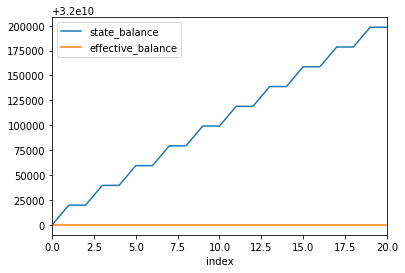

In [8]:
df.reset_index().plot('index', ['state_balance', 'effective_balance'])